Q1:  Implement Logistic Regression using the Pyro library referring [1] for guidance. Show both the mean prediction as well as standard deviation in the predictions over the 2d grid. Use NUTS MCMC sampling to sample the posterior. Take 1000 samples for posterior distribution and use 500 samples as burn/warm up. Use the below given dataset.
```python
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
```

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
from jax import random
sns.set_context("notebook")

In [62]:
try:
    import numpyro
except ImportError:
    %pip install numpyro
    import numpyro

  Obtaining dependency information for numpyro from https://files.pythonhosted.org/packages/f9/e1/545f037aa1d119d83bebb6816d9e01138bb2a2ee5878cdd1c1e76fe3a239/numpyro-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for multipledispatch from https://files.pythonhosted.org/packages/51/c0/00c9809d8b9346eb238a6bbd5f83e846a4ce4503da94a4c08cb7284c325b/multipledispatch-1.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/312.7 kB ? eta -:--:--
   -------------- ------------------------- 112.6/312.7 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------  307.2/312.7 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 312.7/312.7 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
try:
    import pyro
except ImportError:
    %pip install pyro-ppl
    import pyro

In [3]:
import pyro.distributions as dist

In [4]:
from pyro.infer import MCMC, NUTS, Predictive

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [6]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, y_train.shape,X_test.shape, y_test.shape

(torch.Size([80, 2]), torch.Size([80]), torch.Size([20, 2]), torch.Size([20]))

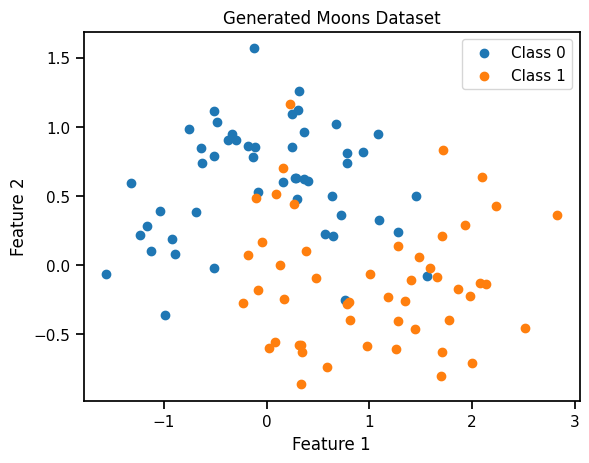

In [7]:
# Separate data points by class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], label="Class 0", marker='o')
plt.scatter(class_1[:, 0], class_1[:, 1], label="Class 1", marker='o')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Moons Dataset")
plt.legend()
plt.show()

In [8]:
def logistic_model(X, y):
    # sample from prior
    w = pyro.sample(
      'w', dist.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1]))
    )
    b = pyro.sample(
      'b', dist.Normal(torch.zeros(1), torch.ones(1))
    )
    with pyro.iarange('data', X.shape[0]):
        model_logits = torch.matmul(X, w) + b
        pyro.sample('obs', dist.Bernoulli(logits=model_logits), obs=y)

In [9]:
nuts_kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(X_train, y_train)

Warmup:   0%|          | 3/1500 [00:00, 25.77it/s, step size=1.20e-01, acc. prob=0.333]

Sample: 100%|██████████| 1500/1500 [00:32, 46.05it/s, step size=6.50e-01, acc. prob=0.929] 


In [10]:
posterior_samples = mcmc.get_samples()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


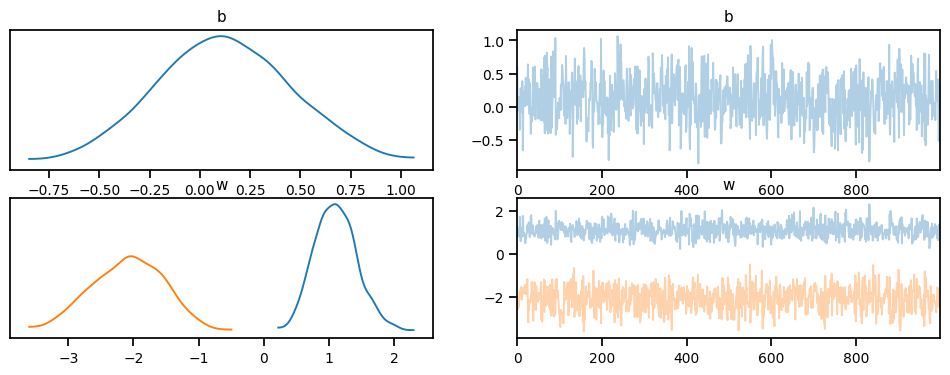

In [11]:
import arviz as az

idata = az.from_pyro(mcmc)
az.plot_trace(idata, compact=True);

In [12]:
posterior_samples['w'].mean(0), posterior_samples['b'].mean(0)

(tensor([ 1.1069, -2.0874]), tensor([0.1179]))

In [13]:
posterior_samples['w'].std(0), posterior_samples['b'].std(0)

(tensor([0.3259, 0.5515]), tensor([0.3369]))

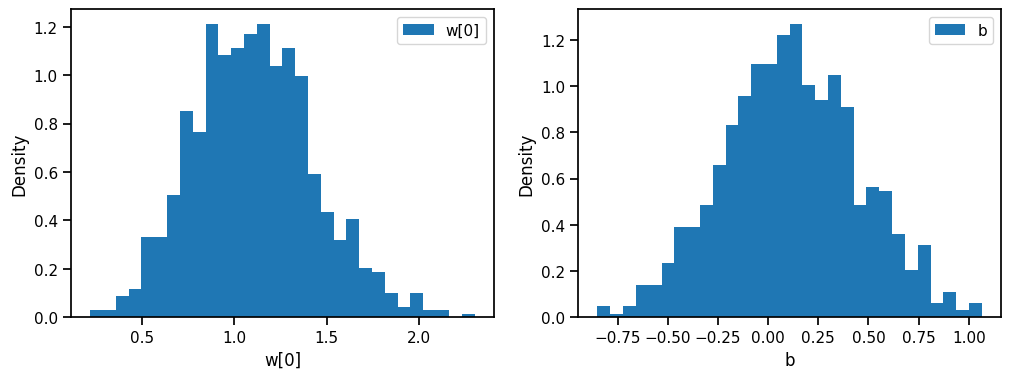

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(posterior_samples['w'][:, 0], bins=30, density=True, label='w[0]')
plt.xlabel('w[0]')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(posterior_samples['b'][:, 0], bins=30, density=True, label='b')
plt.xlabel('b')
plt.ylabel('Density')
plt.legend()

plt.show()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


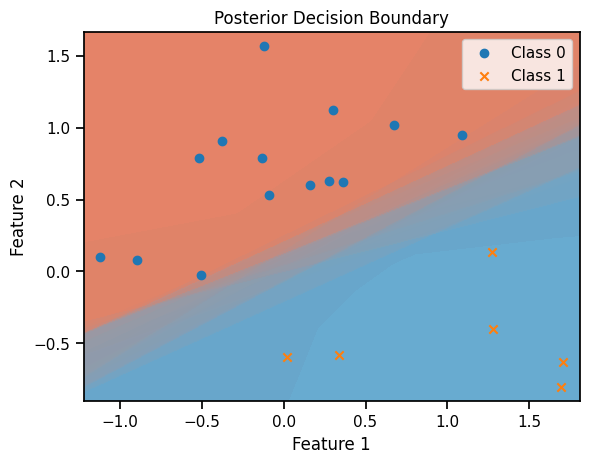

In [15]:
# Define a function to plot the decision boundary
def plot_decision_boundary(X, y, posterior_samples, title="Posterior Decision Boundary"):
    # Create a meshgrid of points for the entire feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))

    # Flatten the meshgrid for prediction
    grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)

    # Get the number of posterior samples
    num_samples = len(posterior_samples['w'])

    # Plot the posterior decision boundary for each sample
    for i in range(num_samples):
        w = posterior_samples['w'][i]
        b = posterior_samples['b'][i]

        # Calculate the logits and probabilities
        logits = torch.matmul(grid, w) + b
        probs = 1 / (1 + torch.exp(-logits))
        probs = probs.detach().numpy().reshape(xx.shape)

        # Plot the decision boundary
        plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, cmap=plt.cm.RdBu)

    # Plot the data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Class 0", marker='o')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Class 1", marker='x')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

# Assuming you have 'X_test' and 'y_test' as your test data and labels
plot_decision_boundary(X_test, y_test, posterior_samples)


In [16]:
X.shape, y.shape

((100, 2), (100,))

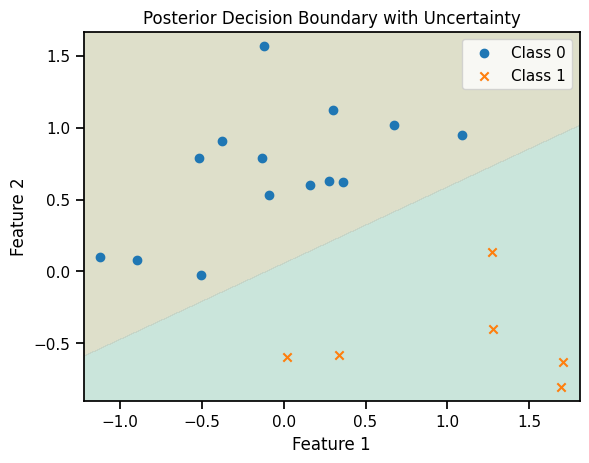

In [17]:
import torch
import matplotlib.pyplot as plt

# Define a function to plot the decision boundary with mean and standard deviation
def plot_decision_boundary_with_uncertainty(X, y, posterior_samples, title="Posterior Decision Boundary"):
    # Create a meshgrid of points for the entire feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))

    # Flatten the meshgrid for prediction
    grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)

    # Get the number of posterior samples
    num_samples = len(posterior_samples['w'])

    # Initialize arrays to store probabilities for all samples
    all_probs = []

    # Calculate and store probabilities for each sample
    for i in range(num_samples):
        w = posterior_samples['w'][i]
        b = posterior_samples['b'][i]

        # Calculate the logits and probabilities
        logits = torch.matmul(grid, w) + b
        probs = 1 / (1 + torch.exp(-logits))
        all_probs.append(probs)

    # Calculate the mean and standard deviation of the probabilities
    mean_probs = torch.mean(torch.stack(all_probs), dim=0)
    std_probs = torch.std(torch.stack(all_probs), dim=0)

    # Plot the mean prediction and standard deviation
    plt.contourf(xx, yy, mean_probs.numpy().reshape(xx.shape), levels=[0, 0.5, 1], alpha=0.2, cmap=plt.cm.RdBu)
    plt.contourf(xx, yy, std_probs.numpy().reshape(xx.shape), levels=[std_probs.min(), std_probs.max()], alpha=0.2, cmap=plt.cm.Greens)

    # Plot the data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Class 0", marker='o')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Class 1", marker='x')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

# Assuming you have 'X_test' and 'y_test' as your test data and labels
plot_decision_boundary_with_uncertainty(X_test, y_test, posterior_samples, title="Posterior Decision Boundary with Uncertainty")


Consider the FVC dataset example discussed in the class. Find the notebook link at [2]. We had only used the train dataset. Now, we want to find out the performance of various models on the test dataset. Use the given dataset and deduce which model works best in terms of error (MAE) and coverage? The base model is Linear Regression by Sklearn (from sklearn.linear_model import LinearRegression). Plot the trace diagrams and posterior distribution. Also plot the predictive posterior distribution with 90% confidence interval.


In [18]:
URL = "https://gist.githubusercontent.com/ucals/" + "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"+ "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"+ "osic_pulmonary_fibrosis.csv"

In [19]:
df = pd.read_csv(URL)
df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [48]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df["Weeks"], df['FVC'], train_size = 0.8, random_state = 0)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")


Training set shape: (1239,)
Testing set shape: (310,)


In [49]:
x_train.describe(), x_test.describe()

(count    1239.000000
 mean       32.629540
 std        23.694116
 min        -5.000000
 25%        12.500000
 50%        29.000000
 75%        48.000000
 max       133.000000
 Name: Weeks, dtype: float64,
 count    310.000000
 mean      28.793548
 std       21.128271
 min       -3.000000
 25%       12.000000
 50%       24.000000
 75%       42.000000
 max       97.000000
 Name: Weeks, dtype: float64)

In [55]:
### Linear regression from scikit-learn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train.values.reshape(-1,1), y_train)

LinearRegression()

In [56]:
all_weeks = np.arange(-12, 134, 1)

Text(0.5, 1.0, 'Linear Regression predictions on test data')

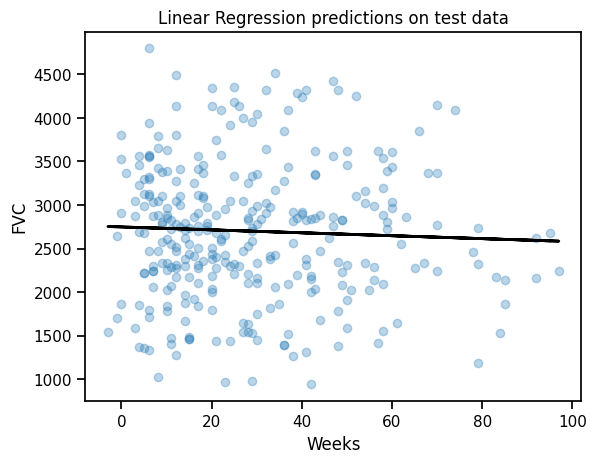

In [93]:
# Plot the data and the regression line
plt.scatter(x_test.values.reshape(-1,1), y_test, alpha=0.3)
plt.plot(x_test, lr.predict(x_test.values.reshape(-1,1)), color="black", lw=2)
plt.xlabel("Weeks")
plt.ylabel("FVC")
plt.title("Linear Regression predictions on test data")

In [58]:
lr.coef_, lr.intercept_

(array([-1.68051699]), 2747.966054074546)

Prediction: Vanilla LR

In [59]:
predictions = lr.predict(x_test.values.reshape(-1, 1))

from sklearn.metrics import mean_absolute_error

maes = {}
maes["LinearRegression"] = mean_absolute_error(y_test.values, predictions)
maes

{'LinearRegression': 626.3184730275215}

### Pooled model

$\alpha \sim \text{Normal}(0, 500)$

$\beta \sim \text{Normal}(0, 500)$

$\sigma \sim \text{HalfNormal}(100)$

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha + \beta \cdot Week_i, \sigma)$



In [131]:
def pooled_model(X, y=None):
    α = numpyro.sample("α", dist.Normal(0., 500.))
    β = numpyro.sample("β", dist.Normal(0., 500.))
    σ = numpyro.sample("σ", dist.HalfNormal(50.))
    with numpyro.plate("samples", len(X)):
        fvc = numpyro.sample("fvc", dist.Normal(α + β * X, σ), obs=y)
    return fvc

In [65]:
import numpyro.distributions as dist

In [ ]:
# import os
# os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [72]:
%pip install graphviz

     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     --------------------------------- ---- 41.0/47.0 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 471.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [132]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
df["patient_code"] = patient_encoder.fit_transform(df["Patient"].values)

In [154]:
sample_patient_code_train = df["patient_code"].values[x_train.index]
sample_patient_code_test = df["patient_code"].values[x_test.index]

In [133]:
from numpyro.infer import MCMC, NUTS, Predictive

In [134]:

nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)


In [135]:
x_train.values.reshape(-1,1).shape, y_train.values.shape

((1239, 1), (1239,))

In [136]:
mcmc.run(rng_key, X=x_train.values, y=y_train.values)
posterior_samples = mcmc.get_samples()

  0%|          | 0/6000 [00:00<?, ?it/s]

sample: 100%|██████████| 6000/6000 [00:02<00:00, 2352.16it/s, 15 steps of size 4.41e-01. acc. prob=0.93]


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

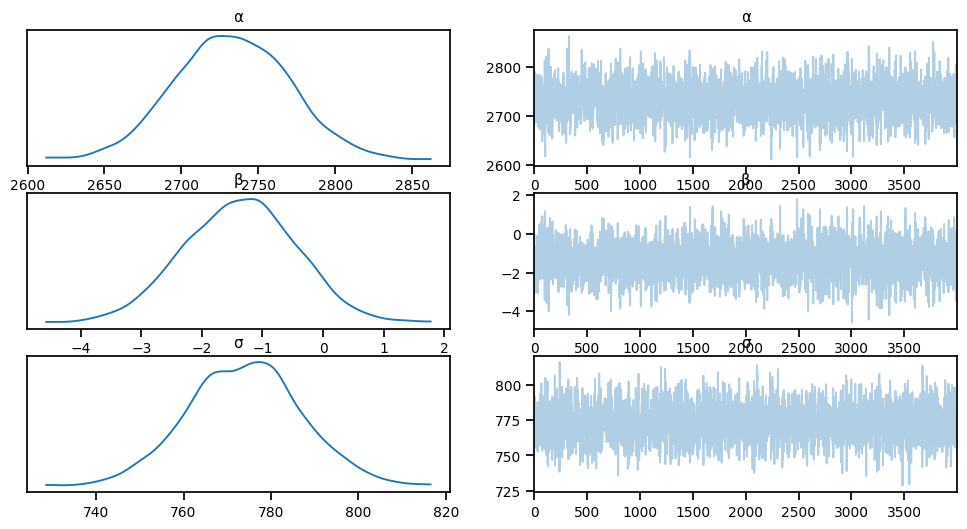

In [137]:
import arviz as az

idata = az.from_numpyro(mcmc)
az.plot_trace(idata, compact=True)

In [215]:
# Summary statistics
az.summary(idata, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2732.55,36.72,2666.72,2804.27,0.86,0.61,1831.78,2063.36,NaN
β,-1.37,0.92,-3.15,0.25,0.02,0.02,1918.32,2020.37,NaN
σ,773.88,12.85,749.97,798.30,0.25,0.18,2569.03,1991.23,NaN


In [216]:
# Predictive distribution
predictive = Predictive(pooled_model, mcmc.get_samples())

In [217]:
predictions = predictive(rng_key, x_test.values, None)

<Axes: >

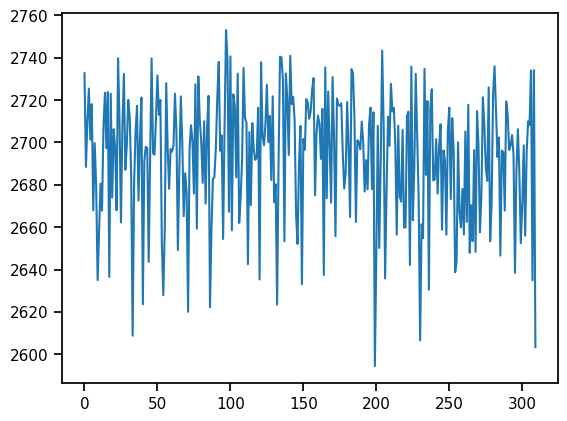

In [218]:
pd.DataFrame(predictions["fvc"]).mean().plot()

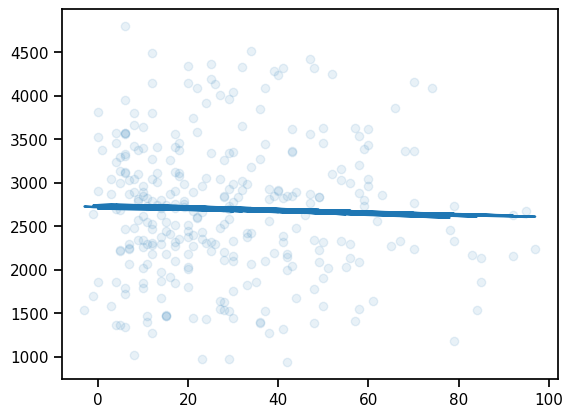

In [219]:
plt.plot(x_test, predictions["fvc"].mean(axis=0))
plt.scatter(x_test, y_test, alpha=0.1)

Text(0, 0.5, 'FVC')

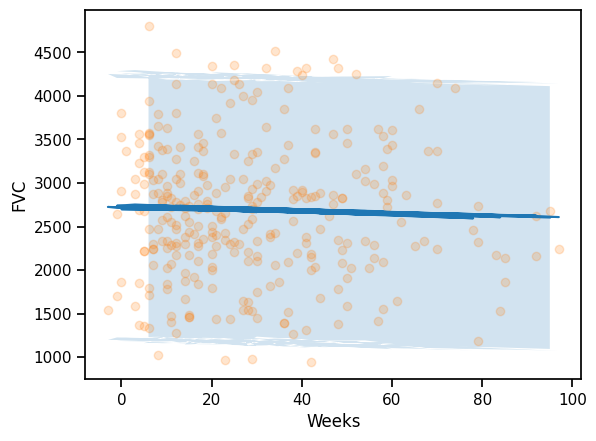

In [220]:
# Get the mean and standard deviation of the predictions
mu = predictions["fvc"].mean(axis=0)
sigma = predictions["fvc"].std(axis=0)

# Plot the predictions
plt.plot(x_test, mu)
plt.fill_between(x_test, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2)
plt.scatter(x_test, y_test, alpha=0.2)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [145]:
preds_pooled  = predictive(rng_key, x_test.values, None)['fvc']
predictions_train_pooled = preds_pooled.mean(axis=0)
std_train_pooled = preds_pooled.std(axis=0)

In [146]:
### Computing Mean Absolute Error and Coverage at 95% confidence interval

maes["PooledModel"] = mean_absolute_error(y_test, predictions_train_pooled)
maes

{'LinearRegression': 626.3184730275215, 'PooledModel': 626.4611966040827}

In [147]:
### Computing the coverage at 95% confidence interval

def coverage(y_true, y_pred, sigma):
    lower = y_pred - 1.96 * sigma
    upper = y_pred + 1.96 * sigma
    return np.mean((y_true >= lower) & (y_true <= upper))
coverages = {}
coverages["pooled"] = coverage(y_test, predictions_train_pooled, std_train_pooled).item()
coverages

{'pooled': 0.9483870967741935}

### Hierarchical model

$\sigma \sim \text{HalfNormal}(100)$

---

$\mu_{\alpha} \sim \text{Normal}(0, 500)$

$\sigma_{\alpha} \sim \text{HalfNormal}(100)$

$\mu_{\beta} \sim \text{Normal}(0, 500)$

$\sigma_{\beta} \sim \text{HalfNormal}(100)$

---

`for p in range(N_patients):`

$\alpha_p \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$

$\beta_p \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$

---

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha_{p[i]} + \beta_{p[i]} \cdot Week_i, \sigma)$


In [148]:
### Hierarchical model

def partial_pool_same_sigma(sample_weeks, sample_patient_code, sample_fvc=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(sample_patient_code))

    with numpyro.plate("Participants", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[sample_patient_code] + β[sample_patient_code] * sample_weeks

    with numpyro.plate("data", len(sample_patient_code)):
        numpyro.sample("fvc", dist.Normal(FVC_est, σ), obs=sample_fvc)

In [150]:
nuts_ppss = NUTS(partial_pool_same_sigma)

mcmc_ppss = MCMC(nuts_ppss, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

In [157]:
model_kwargs = {"sample_weeks": x_train.values,
                "sample_patient_code": sample_patient_code_train,
                "sample_fvc":y_train.values}

In [158]:
mcmc_ppss.run(rng_key, **model_kwargs)

sample: 100%|██████████| 6000/6000 [00:43<00:00, 137.00it/s, 63 steps of size 1.26e-02. acc. prob=0.85] 


In [161]:
predictive_ppss = Predictive(partial_pool_same_sigma, mcmc_ppss.get_samples())

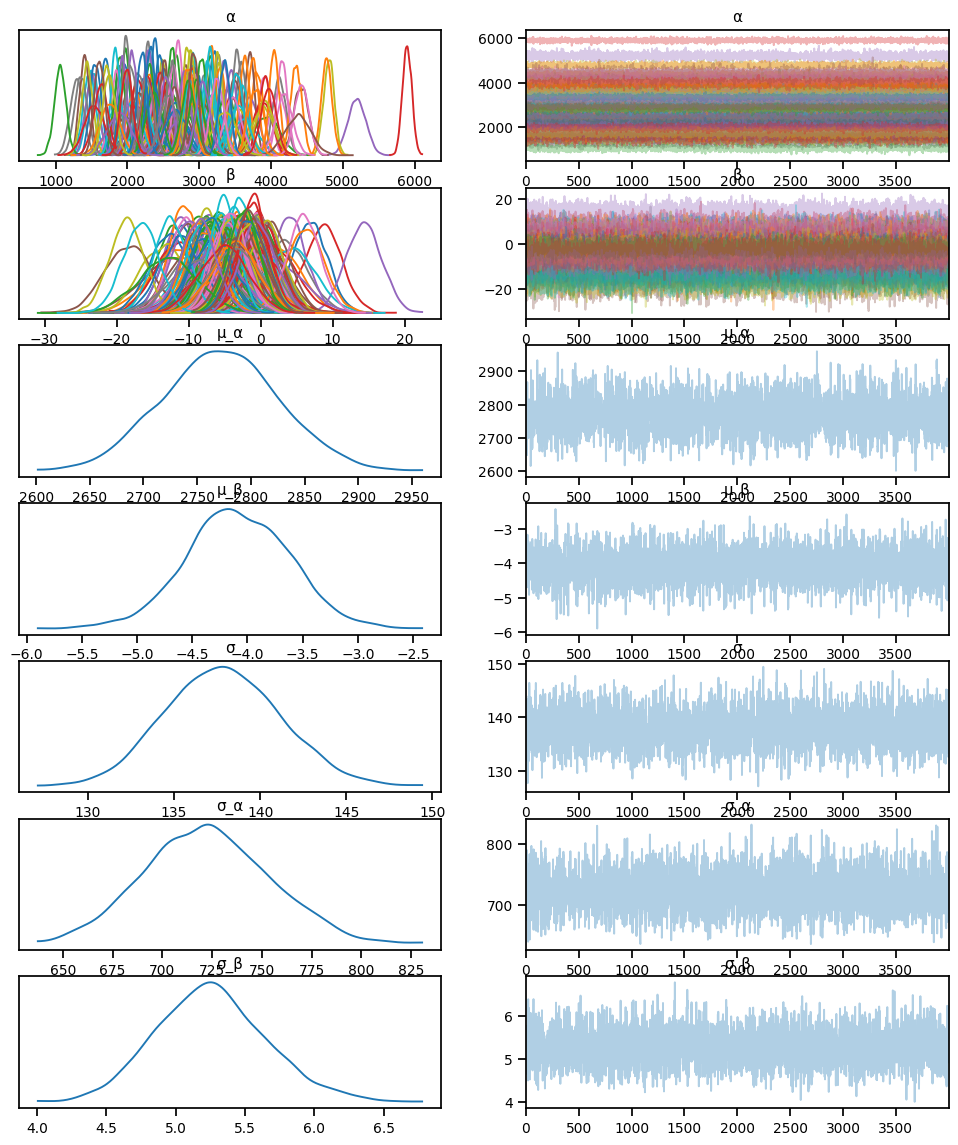

In [162]:
az.plot_trace(az.from_numpyro(mcmc_ppss), compact=True)

In [163]:
predictive_ppss = Predictive(partial_pool_same_sigma, mcmc_ppss.get_samples())


In [167]:
predictions_test_ppss = predictive_ppss(rng_key,
                                                         sample_weeks = x_test.values,
                                                         sample_patient_code = sample_patient_code_test)['fvc']

mu_predictions_test_h = predictions_test_ppss.mean(axis=0)
std_predictions_test_h = predictions_test_ppss.std(axis=0)

maes["PatrialPooled_samesigma"] = mean_absolute_error(y_test, mu_predictions_test_h)

coverages["PatrialPooled_samesigma"] = coverage(y_test, mu_predictions_test_h, std_predictions_test_h).item()

print(maes)
print(coverages)

{'LinearRegression': 626.3184730275215, 'PooledModel': 626.4611966040827, 'Hierarchical': 110.46457322643649, 'PatrialPooled_samesigma': 110.46457322643649}
{'pooled': 0.9483870967741935, 'Hierarchical': 0.9419354838709677, 'PatrialPooled_samesigma': 0.9419354838709677}


In [221]:
# Predict for a given patient


def predict_ppss(patient_code):
    predictions = predictive_ppss(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_ppss(patient_code):
    mu, sigma = predict_ppss(patient_code)
    plt.scatter(all_weeks, mu)
    plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = x_test.values[sample_patient_code_test == patient_code]
    patient_fvc = y_test.values[sample_patient_code_test == patient_code]
    # patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    # patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.8, label="Test Set", color="black")
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.legend()
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

def plot_total_ppss(patient_id = 0, plot_pooled = False):
    print(all_weeks.shape)
    print(mu.shape)
    plot_patient_ppss(np.array([patient_id]))
    print(all_weeks.shape)
    print(mu.shape)
    if plot_pooled:
        plt.plot(all_weeks, mu, color='g')
        plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.05, color='g')


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


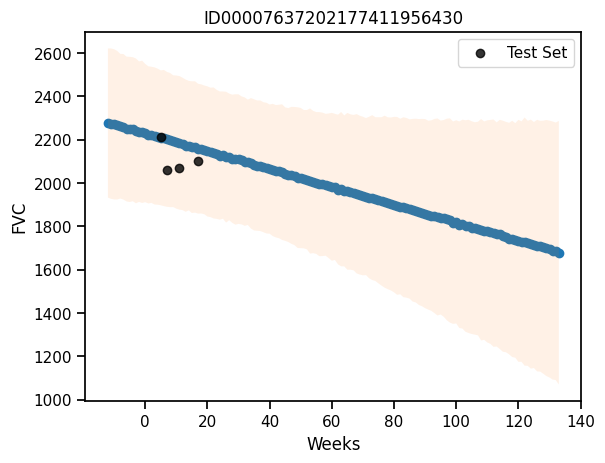

In [222]:
# plot for a given patient
plot_patient_ppss(np.array([0]))

In [225]:
predictions_test_ppss = predictive_ppss(rng_key,
                                                 x_test.values,
                                                 sample_patient_code_test)['fvc']
predictions_test_ppss.shape

(4000, 310)

In [226]:
mu_predictions_test_ppss = predictions_test_ppss.mean(axis=0)
std_predictions_test_ppss = predictions_test_ppss.std(axis=0)

maes["PartiallyPooled_samesigma"] = mean_absolute_error(y_test, mu_predictions_test_ppss)
maes

{'LinearRegression': 626.3184730275215,
 'PooledModel': 626.4611966040827,
 'Hierarchical': 110.46457322643649,
 'PatrialPooled_samesigma': 110.46457322643649,
 'PartiallyPooled_samesigma': 110.46457322643649}

### Hierarchical model

$\gamma_{\sigma} \sim \text{HalfNormal}(30)$

$\mu_{\alpha} \sim \text{Normal}(0, 500)$

$\sigma_{\alpha} \sim \text{HalfNormal}(100)$

$\mu_{\beta} \sim \text{Normal}(0, 500)$

$\sigma_{\beta} \sim \text{HalfNormal}(100)$

---

`for p in range(N_patients):`

$\alpha_p \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$

$\beta_p \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$

$\sigma_p \sim \text{Exp}(\gamma_{\sigma})$


---

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha_{p[i]} + \beta_{p[i]} \cdot Week_i, \sigma_{p[i]})$


In [236]:
### Hierarchical model

def partial_pool_hyper_sigma(sample_weeks, sample_patient_code, sample_fvc=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))
    gamma_sigma = numpyro.sample("gamma_sigma", dist.HalfNormal(30))


    n_patients = len(np.unique(sample_patient_code))

    with numpyro.plate("Participants", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))
        σ = numpyro.sample("σ", dist.Exponential(gamma_sigma))
    FVC_est = α[sample_patient_code] + β[sample_patient_code] * sample_weeks

    with numpyro.plate("data", len(sample_patient_code)):
        numpyro.sample("fvc", dist.Normal(FVC_est, σ[sample_patient_code]), obs=sample_fvc)

In [241]:
nuts_pphs = NUTS(partial_pool_hyper_sigma)

mcmc_pphs = MCMC(nuts_pphs, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

In [242]:
y_train.shape

(1239,)

In [243]:
model_kwargs = {"sample_weeks": x_train.values,
                "sample_patient_code": sample_patient_code_train,
                "sample_fvc":y_train.values}

In [244]:
mcmc_pphs.run(rng_key, **model_kwargs)

sample: 100%|██████████| 6000/6000 [02:06<00:00, 47.47it/s, 511 steps of size 8.39e-03. acc. prob=0.94] 


In [245]:
predictive_pphs = Predictive(partial_pool_hyper_sigma, mcmc_pphs.get_samples())

array([[<Axes: title={'center': 'gamma_sigma'}>,
        <Axes: title={'center': 'gamma_sigma'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'μ_α'}>, <Axes: title={'center': 'μ_α'}>],
       [<Axes: title={'center': 'μ_β'}>, <Axes: title={'center': 'μ_β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_α'}>, <Axes: title={'center': 'σ_α'}>],
       [<Axes: title={'center': 'σ_β'}>, <Axes: title={'center': 'σ_β'}>]],
      dtype=object)

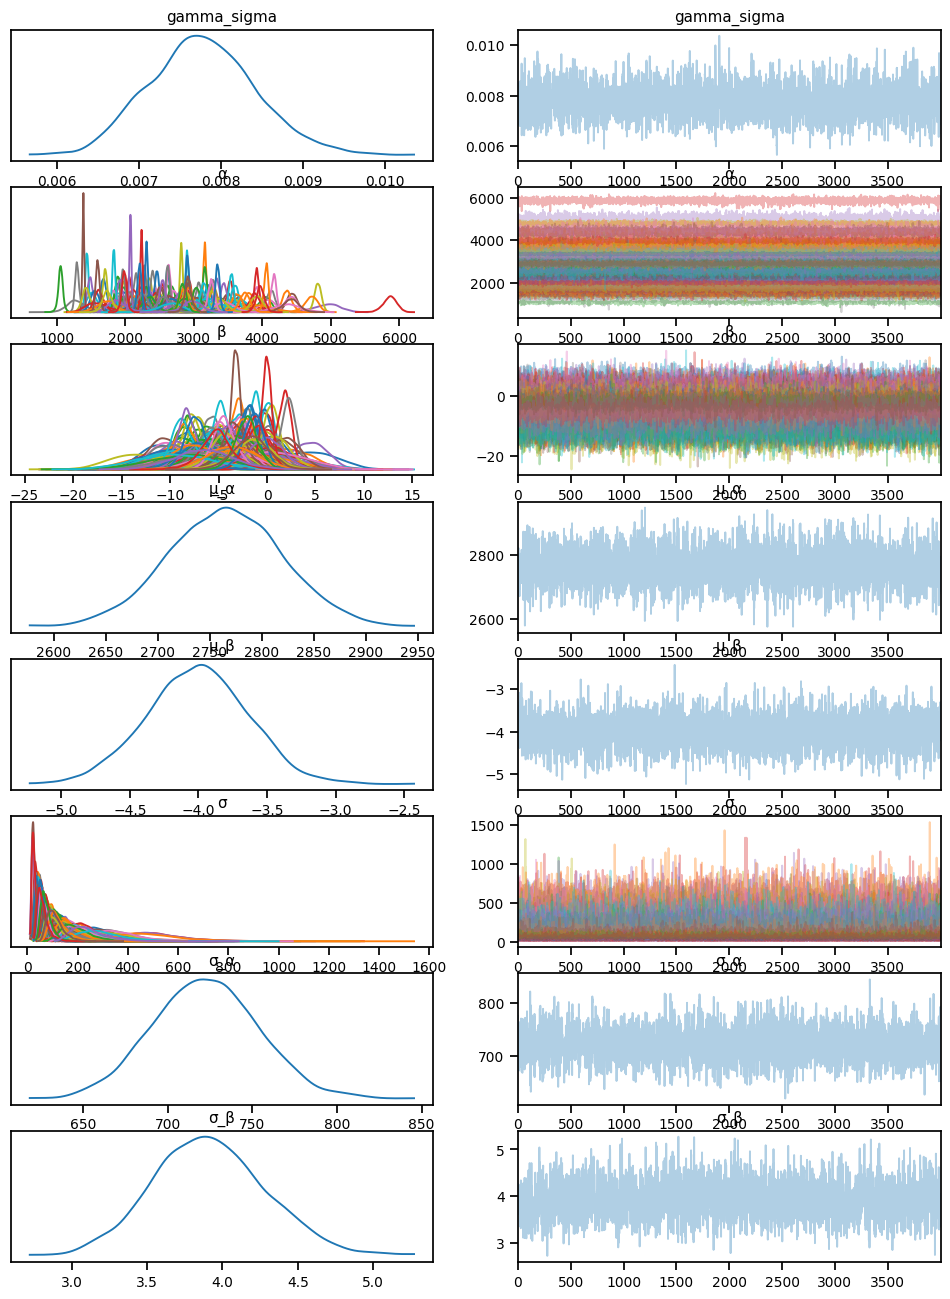

In [247]:
az.plot_trace(az.from_numpyro(mcmc_pphs), compact=True)

In [251]:
predictions_test_pphs = predictive_pphs(rng_key,
                                                         sample_weeks = x_test.values,
                                                         sample_patient_code = sample_patient_code_test)['fvc']

mu_predictions_test_h = predictions_test_pphs.mean(axis=0)
std_predictions_test_h = predictions_test_pphs.std(axis=0)

maes["PatrialPooled_hypersigma"] = mean_absolute_error(y_test, mu_predictions_test_h)

coverages["PatrialPooled_hypersigma"] = coverage(y_test, mu_predictions_test_h, std_predictions_test_h).item()

print(maes)
print(coverages)

{'LinearRegression': 626.3184730275215, 'PooledModel': 626.4611966040827, 'Hierarchical': 110.46457322643649, 'PatrialPooled_samesigma': 110.46457322643649, 'PartiallyPooled_samesigma': 110.46457322643649, 'PatrialPooled_hypersigma': 111.37391593686996}
{'pooled': 0.9483870967741935, 'Hierarchical': 0.9419354838709677, 'PatrialPooled_samesigma': 0.9419354838709677, 'PatrialPooled_hypersigma': 0.9451612903225807}


In [252]:
# Predict for a given patient


def predict_pphs(patient_code):
    predictions = predictive_pphs(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_pphs(patient_code):
    mu, sigma = predict_pphs(patient_code)
    plt.scatter(all_weeks, mu)
    plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = x_test.values[sample_patient_code_test == patient_code]
    patient_fvc = y_test.values[sample_patient_code_test == patient_code]
    # patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    # patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.8, label="Test Set", color="black")
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.legend()
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

def plot_total_pphs(patient_id = 0, plot_pooled = False):
    print(all_weeks.shape)
    print(mu.shape)
    plot_patient_pphs(np.array([patient_id]))
    print(all_weeks.shape)
    print(mu.shape)
    if plot_pooled:
        plt.plot(all_weeks, mu, color='g')
        plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.05, color='g')


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


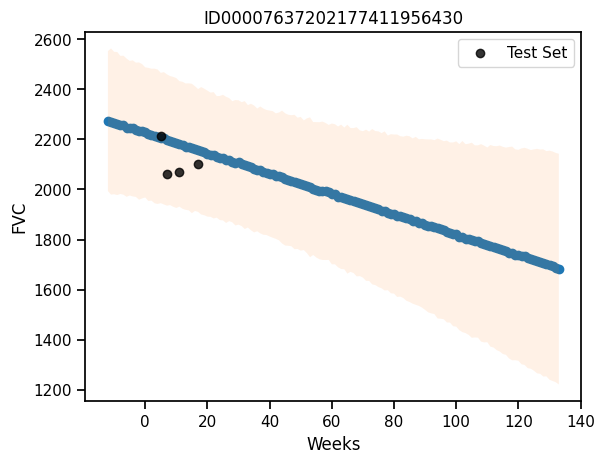

In [254]:
# plot for a given patient
plot_patient_pphs(np.array([0]))